# Statistical foundations of machine learning - <span style="color:#1CA766">INFO-F-422</span>
# Project: <span style="color:#1CA766">House Prices: Advanced Regression Techniques</span>

> ## <span style="color:#2E66A7"> Alberto Parravicini</span>

*****

# <span style="color:#1CA766">Part 1:</span> Introduction

The goal of the project was to participate in the [*"House Prices: Advanced Regression Techniques"*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) challenge hosted on *Kaggle*: starting from a dataset of about $1400$ houses sold in [*Ames, Iowa*](https://www.google.com/maps/place/Ames,+Iowa/@42.0257347,-93.6660439,12z/data=!4m5!3m4!1s0x87ee70624634a06b:0x273156083cc75200!8m2!3d42.0307812!4d-93.6319131), we are asked to predict the sale price of another set of $1400$ houses.

Each house is described by a multitude of attributes, both categorical and numerical, that are relative not only to the house itself, but also to the specific conditions of the sale.  
This is important as we are not asked to predict the price of houses that will be sold in the future, but to infer the value of houses that have been already sold, but for which the price is missing.

In this report I will show how to effectively **explore** the dataset to spot interesting structures in our data, how to **build many new features** from the existing ones in order to gain even more predictive power, and finally how to **predict** the sale prices by tuning and combining **SVM**, **ridge regresssion** and **neural networks**.

### <span style="color:#2E66A7">Acknowledgements</span>:

Many of the ideas, techiques and tricks that are presented in this report are based on the work of other partecipants in the challenge:

* https://www.kaggle.com/tannercarbonati/detailed-data-analysis-ensemble-modeling
* https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion/32381
* https://www.kaggle.com/apapiu/regularized-linear-models/
* https://www.kaggle.com/notaapple/detailed-exploratory-data-analysis-using-r/
* https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset/
* https://www.kaggle.com/laurae2/plotting-all-data/
* https://www.kaggle.com/juliensiems/cleaning-new-features-gps-coordinates-included/
* https://www.kaggle.com/mariopasquato/does-rounding-help/


### <span style="color:#2E66A7">Note</span>: 

Sometimes the plots made with **Bokeh** might fail to load, it is a known bug with the library. If this happens, **re-running** the cell with the plot in question seems to fix the issue.

*****

# <span style="color:#1CA766">Part 2:</span> Data Exploration

Before even trying to build any model, it is extremely important to have a good understanding of the structure and the patterns in our data.  
An accurate data exploration can tell us many useful things that will be useful later on, when it is time to clean the data or create new features or understand why our models are not behaving as well as we would like to!

In [4]:
rm(list=ls())

library(readr)
library(purrr)
library(tidyr)
library(rbokeh)
library(plyr)
library(tidyr)
library(ggplot2)
library(sqldf)
library(xtable)
library(dplyr)
library(moments)
library(corrplot)
library(tabplot)
library(ICC)


# Import the data
train <- read_csv("~/machine-learning-ulb/data/train.csv")
test <- read_csv("~/machine-learning-ulb/data/test.csv")

Parsed with column specification:
cols(
  .default = col_character(),
  Id = col_integer(),
  MSSubClass = col_integer(),
  LotFrontage = col_integer(),
  LotArea = col_integer(),
  OverallQual = col_integer(),
  OverallCond = col_integer(),
  YearBuilt = col_integer(),
  YearRemodAdd = col_integer(),
  MasVnrArea = col_integer(),
  BsmtFinSF1 = col_integer(),
  BsmtFinSF2 = col_integer(),
  BsmtUnfSF = col_integer(),
  TotalBsmtSF = col_integer(),
  `1stFlrSF` = col_integer(),
  `2ndFlrSF` = col_integer(),
  LowQualFinSF = col_integer(),
  GrLivArea = col_integer(),
  BsmtFullBath = col_integer(),
  BsmtHalfBath = col_integer(),
  FullBath = col_integer()
  # ... with 18 more columns
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  Id = col_integer(),
  MSSubClass = col_integer(),
  LotFrontage = col_integer(),
  LotArea = col_integer(),
  OverallQual = col_integer(),
  OverallCond = col_integer(),
  YearBuilt = co

In [10]:
# Print header
head(train)
# Count column types
table(sapply(train, class))
# Shape of train and test sets.
print(paste("Train-set shape:", nrow(train), "x", ncol(train)))
print(paste("Test-set shape:", nrow(test), "x", ncol(test)))

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,...,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000



character   integer 
       43        38 

[1] "Train-set shape: 1460 x 81"
[1] "Test-set shape: 1459 x 80"


Just right after importing the data, we can see a few things:
* The dataset contains roughly the same number of numerical and categorical features. We would like to have a dataset which is **completely numerical**, as many powerful models can only work with numerical features.  
How to appropriately convert the categorical features into numbers depends on their meaning, and will be something we should worry about very soon.
* The train and test set have roughly the **same amount of rows**. 
* Many of the columns seem to contain **NA** values. It is very likely that these NA values have an intrinsic meaning, and aren't simply missing from the dataset. If this is the case, we have to be very careful when handling them!

***

###  <span style="color:#2E66A7">Analysis of the response variable</span>

The first thing we should focus our attention on is the **response variable**, the **sale price** of the houses.  
Knowing the number of bathrooms or the size of the pool will be of very little help if we don't know what we are trying to predict!

In [16]:
p <- figure() %>%
    ly_hist(SalePrice, data=train, breaks=30, freq=F, legend="Sale price histogram") %>%
    ly_density(rnorm(n=800000, mean=mean(train$SalePrice), sd=sd(train$SalePrice)), line_dash=1, width=2, alpha=0.4, color="#F08080", legend="Normal density")
rbokeh2html(p,'./out.html')
IRdisplay::display_html(file='./out.html')
# The sale price is clearly not normal! 
# It is skewed to the right, and leptokurtic.
summary(train$SalePrice)
shapiro.test(train$SalePrice)
print(paste("SKEW=", skewness(train$SalePrice)))
print(paste("KURTOSIS=", kurtosis(train$SalePrice)))

html file written to: ./out.html


<!DOCTYPE html>

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  34900  130000  163000  180900  214000  755000 


	Shapiro-Wilk normality test

data:  train$SalePrice
W = 0.86967, p-value < 2.2e-16


[1] "SKEW= 1.88094074603404"
[1] "KURTOSIS= 9.50981201108944"


Here we can see how the sale prices are distributed.  
They are all positive (which isn't such an obvious thing, some rows could have dirty data!), and they are centered at around $160000\$$.  

Along with the prices histogram we can see what a gaussian distribution with the same mean and variance looks like.  
Our data are heavily **skewed** to the right (as we can see from the large number of houses with high price), and with a *kurtosis* of 9, the distribution is very **leptokurtic**, i.e. it is more *"pointy"* than a regular gaussian, which would have a *kurtosis* of $3$.  
The *Shapiro-Wilk* test also confirms that our data are nowhere close to being normal, with a *p-value* that is basically $0$.

Why should we care?  
Because most models, especially the ones derived from linear models, assume the distributions of the variables to be normally distributed.   
In our current scenario, houses with high price will have a bigger impact than the cheaper ones, and the model will perform poorly.  

Luckily, we can overcome this issue by taking the $log$ of the prices: this usually reduces the positive skew, and makes our distribution more symmetric. To be more precise, we will consider the $log(1 + price)$, in order to avoid problems with the logarithm of $0$; this isn't a problem for the sale price, but it will be important for some other variables which have $0$ values.

In [18]:
# Instead, we can trasform it as log(1 + x) (+1 so no problems with values = 0)
log_price = log(1 + train$SalePrice)

p <- figure() %>%
  ly_hist(log_price, breaks=30, freq=F, legend="Sale price histogram") %>%
  ly_density(rnorm(n=800000, mean=mean(log_price), sd=sd(log_price)), line_dash=1, width=2, alpha=0.4, color="#F08080", legend="Normal density")
rbokeh2html(p,'./out.html')
IRdisplay::display_html(file='./out.html')

summary(log_price)
shapiro.test(log_price)
print(paste("SKEW=", skewness(log_price)))
print(paste("KURTOSIS=", kurtosis(log_price)))

html file written to: ./out.html


<!DOCTYPE html>

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.46   11.78   12.00   12.02   12.27   13.53 


	Shapiro-Wilk normality test

data:  log_price
W = 0.99121, p-value = 1.149e-07


[1] "SKEW= 0.121221913115297"
[1] "KURTOSIS= 3.80264271074681"


See?  
With just a small trick we almost completely removed the **skew**, and the **kurtosis** is almos very close to $3$.  
The *Shapiro-Wilk* normality test is still not very happy about the normality of our data, but for all intent and purposes we can already be satisfied with what we got.

***

###  <span style="color:#2E66A7">Analysis of the categorical features</span>

After getting an intuition of what the distribution of the sale prices is, we can proceed to give a look at the remaining part of our data. Will the number of bathrooms show something interesting?  
Here we'll quickly give a look at the distributions of the categorical classes, to get a general feeling of how their structure.
We'll come back again later at some of these features, to handle missing values and to see how they are related to the sale price.

In [22]:
train_char <- train[, sapply(train, class)=="character"]
test_char <- test[, sapply(test, class)=="character"]

train_char$Type <- "train"
test_char$Type <- "test"

all_char <- rbind(train_char, test_char)

lapply(train_char, table)

$MSZoning

C (all)      FV      RH      RL      RM 
     10      65      16    1151     218 

$Street

Grvl Pave 
   6 1454 

$Alley

Grvl Pave 
  50   41 

$LotShape

IR1 IR2 IR3 Reg 
484  41  10 925 

$LandContour

 Bnk  HLS  Low  Lvl 
  63   50   36 1311 

$Utilities

AllPub NoSeWa 
  1459      1 

$LotConfig

 Corner CulDSac     FR2     FR3  Inside 
    263      94      47       4    1052 

$LandSlope

 Gtl  Mod  Sev 
1382   65   13 

$Neighborhood

Blmngtn Blueste  BrDale BrkSide ClearCr CollgCr Crawfor Edwards Gilbert  IDOTRR 
     17       2      16      58      28     150      51     100      79      37 
MeadowV Mitchel   NAmes NoRidge NPkVill NridgHt  NWAmes OldTown  Sawyer SawyerW 
     17      49     225      41       9      77      73     113      74      59 
Somerst StoneBr   SWISU  Timber Veenker 
     86      25      25      38      11 

$Condition1

Artery  Feedr   Norm   PosA   PosN   RRAe   RRAn   RRNe   RRNn 
    48     81   1260      8     19     11     26      2   

Here we extract the features that are considered characters, and write down the number of occurrences of each label.  
The result is rather hard to interpret, and more detailed analysis have to be carried out. 

Still, by quickly scolling the list we can immediately spot some interesting stuff:
* Many features have a dominant value, and the number of occurrences of the other labels is very small. This happens, for instance, in the **Electrical** feature, or in the **Heating** feature. Most houses seems to have the same characteristics with respect to these 2 features. Standard Circuit Breakers and Gas heating are the way to go in Ames!
* NA values are not shown, but in some cases they form the majority of the occurrences, as in the case of **PoolQC** (pool quality). We should look more in details at NA values, later on.
* Some features are automatically treated as numeric, while they should behave like categorical features. An example is **MSSubClass**, the type of dwelling. We'll look later at these cases.

What should we do in light of these information? In some cases, we could think of grouping together the most uncommon labels, or to drop a column entirely.  
However, labels with rare occurrences could also be strong predictors, for the houses that have them.
We'll finalize our approach later, on a case-by-case basis

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

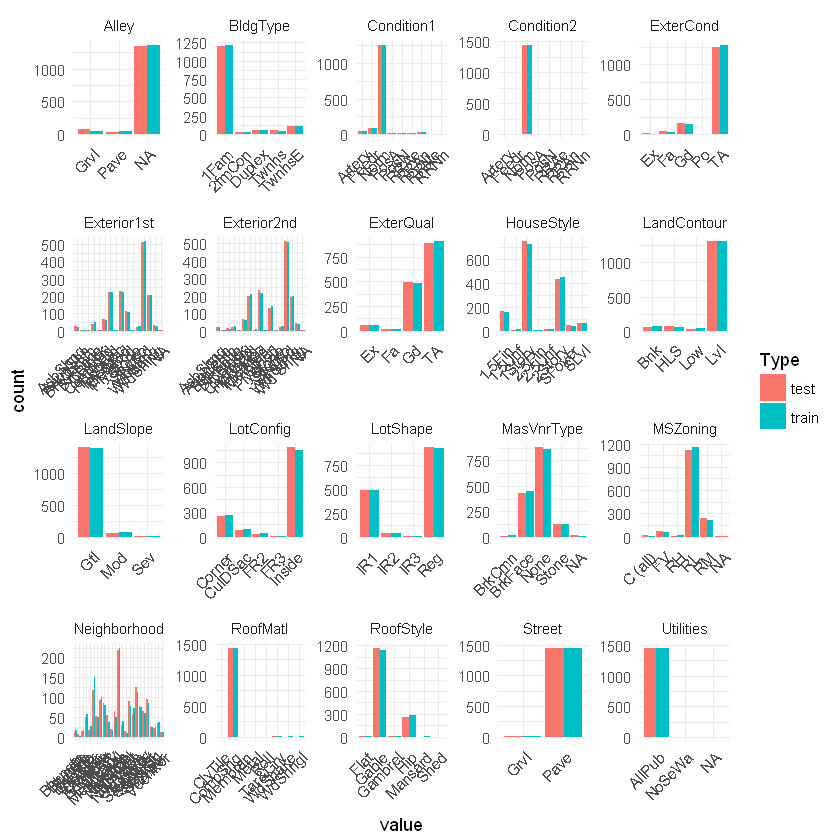

In [20]:
# Compare the distributions of the train and test set.

# 2 different plots, just to have bigger plots
names <- colnames(all_char)
all_char %>%
  gather(key, value, -Type) %>% 
  filter(key %in% names[1:20]) %>%
  ggplot(aes(value, fill=Type)) +
  facet_wrap(~ key, scales = "free") +
  geom_histogram(stat="count", position="dodge") +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

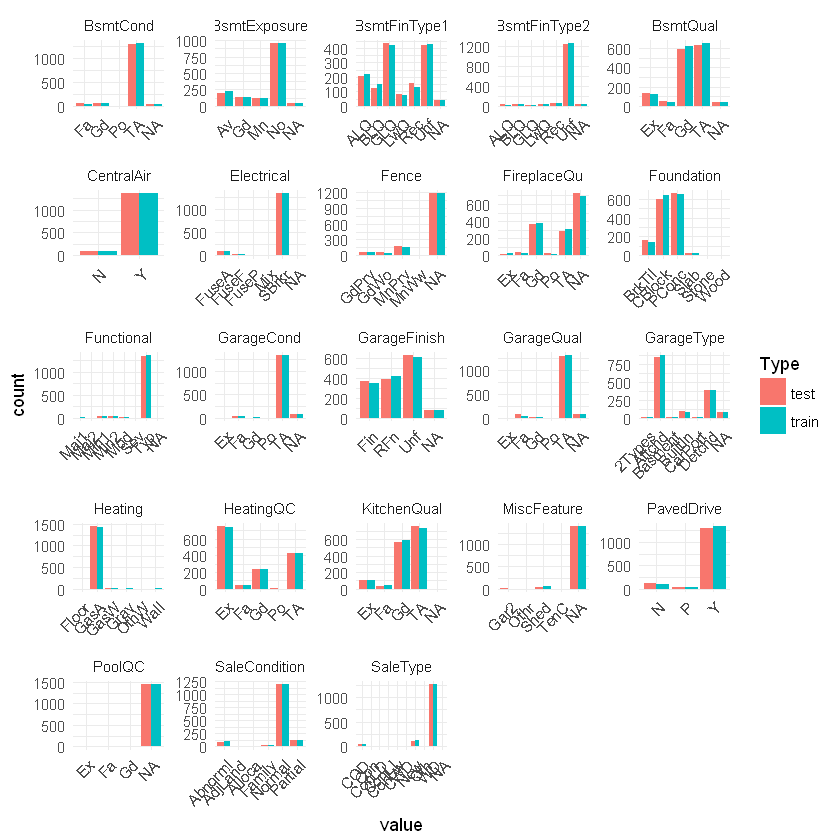

In [21]:
all_char %>%
  gather(key, value, -Type) %>% 
  filter(key %in% names[21:length(names)]) %>%
  ggplot(aes(value, fill=Type)) +
  facet_wrap(~ key, scales = "free") +
  geom_histogram(stat="count", position="dodge") +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

We can plot the distributions of all the categorical features.  
Even though we cannot really distinguish the details of most features, it is still a good way to get a glance of how the labels are spread.  

As we also have available the test set, we can look at its distribution too. Our model can be effective only if the features in the training set, on which the model is built, are distributed in the same way as in the test set.  
Overall we cannot spot any weird incongruency, and we can notice once again how many features have a dominant label.

In [23]:
# List of character columns with a single very common value
maxperc <- sapply(train_char, function(x) max(table(x)) / length(x))
common <- colnames(train_char)[maxperc > 0.9]
for(c in common)
{
  print(paste(c, ": ", names(which.max(table(train_char[, c]))), ", ", maxperc[c]))
}

[1] "Street :  Pave ,  0.995890410958904"
[1] "Utilities :  AllPub ,  0.999315068493151"
[1] "LandSlope :  Gtl ,  0.946575342465753"
[1] "Condition2 :  Norm ,  0.98972602739726"
[1] "RoofMatl :  CompShg ,  0.982191780821918"
[1] "Heating :  GasA ,  0.978082191780822"
[1] "CentralAir :  Y ,  0.934931506849315"
[1] "Electrical :  SBrkr ,  0.913698630136986"
[1] "Functional :  Typ ,  0.931506849315068"
[1] "GarageCond :  TA ,  0.908219178082192"
[1] "PavedDrive :  Y ,  0.917808219178082"
[1] "Type :  train ,  1"


These features have a very common label that appears in more that $90\%$ of the rows!

***

###  <span style="color:#2E66A7">Analysis of the numerical features</span>

Let's now look at the numerical features: once again, for the time being we only want to see a general view of the data, to spot glaring inconsistencies or weird patterns.  
We'll look at them again later on, more in details.

First, let's print for each feature it's summary statistics. This is mainly useful to see if there are dirty data, or values with unexpected scales.

In [24]:
train_num <- keep(train, is.numeric)
sapply(train_num, summary)

# No negative values -> GOOD
# A bunch of NA's -> NOT SO GOOD
#   LotFrontage NA's are probably == 0;

$Id
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   365.8   730.5   730.5  1095.0  1460.0 

$MSSubClass
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   20.0    20.0    50.0    56.9    70.0   190.0 

$LotFrontage
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  21.00   59.00   69.00   70.05   80.00  313.00     259 

$LotArea
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1300    7554    9478   10520   11600  215200 

$OverallQual
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.000   6.000   6.099   7.000  10.000 

$OverallCond
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.000   5.000   5.575   6.000   9.000 

$YearBuilt
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1872    1954    1973    1971    2000    2010 

$YearRemodAdd
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1950    1967    1994    1985    2004    2010 

$MasVnrArea
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0     0.0     0.0   103.7   

MasVnrType
NA
NA
NA
NA
NA
NA
NA
NA


We can notice the following that there are no negative values, which is a sign that our data could be quite clean already.

However there are some NA's:
* **LotFrontage** has a large number of NA's; it could be a sign that those values are equal to $0$ (as the minimum is $20$), but it doesn't make much sense that a house is not connected to a street. Maybe some more complex handling for the missing data will be needed.
* **MasVnrArea** and **GarageYrBlt** have a few NA's: it could mean that these houses don't have masonry veneer walls or a garage.

Also, as mentioned earlier there are some features that are treated as numerical, but are intrinsically categorical or ordinal, such as **MSSubClass** and **GarageYrBlt**. **Id** is also considered, but we can ignore it.

In [25]:
#   Are MasVnrArea NA's == 0 ?
train[is.na(train$MasVnrArea), "MasVnrType"]

MasVnrType
NA
NA
NA
NA
NA
NA
NA
NA


They are NA too! We could remove those observations (they are just 8), or the entire feature if it isn't very useful (for instance, if it has little correlation with the output).
Another option is just to replace the missing values with "None" and "0", which is the most common pair.
This approach will reduce a bit the variance of the columns, but for just 8 rows it shouldn't be a big deal.

In [31]:
# What about the houses with NA in garage?
train[is.na(train$GarageYrBlt), c("GarageType", "GarageFinish", "GarageCars", "GarageArea", "GarageQual")]

GarageType,GarageFinish,GarageCars,GarageArea,GarageQual
NA,NA,0,0,NA
NA,NA,0,0,NA
NA,NA,0,0,NA
NA,NA,0,0,NA
NA,NA,0,0,NA
NA,NA,0,0,NA
NA,NA,0,0,NA
NA,NA,0,0,NA
NA,NA,0,0,NA
NA,NA,0,0,NA


NA's and 0 in garage-related columns are related to the absence of garages.
We can keep the $0$ in numerical features, and replace NA with "None" in categorical features.

Years are more problematic, if treated as numeric, as there isn't a natural *"default"* value that can be assigned to them.
We could convert it to categorical and add a "None" column, or just remove the feature, if superfluous.
We could also replace the missing value with the year the house was built, or with a $0$, and let the model learn to discriminate.  
In any case, it will be necessary to add a binary feature that tells whether a garage is present or not.

What about the test set?

In [32]:
test_num <- keep(test, is.numeric)
sapply(test_num, summary)

$Id
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1461    1826    2190    2190    2554    2919 

$MSSubClass
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  20.00   20.00   50.00   57.38   70.00  190.00 

$LotFrontage
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  21.00   58.00   67.00   68.58   80.00  200.00     227 

$LotArea
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1470    7391    9399    9819   11520   56600 

$OverallQual
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.000   6.000   6.079   7.000  10.000 

$OverallCond
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.000   5.000   5.554   6.000   9.000 

$YearBuilt
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1879    1953    1973    1971    2001    2010 

$YearRemodAdd
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1950    1963    1992    1984    2004    2010 

$MasVnrArea
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0     0.0     0.0   100.7   

We see a couple of ugly things:
* There are more features with NA's; often just 1 or 2 missing values, however, which means that these data are a bit dirtier that the training set.
* There is 1 row with NA's in features relative to the basement. 
* This house however doesn't have a basement, so we can replace the NA's with 0

In [35]:
test[is.na(test$BsmtFinSF1), "BsmtFinType1"]
test[is.na(test$BsmtFinSF2), "BsmtFinType2"]
# There is a second row with dirty data, and no basement.
basement_row <- test[is.na(test$BsmtFullBath), ]
basement_row

BsmtFinType1
NA


BsmtFinType2
NA


Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2121,20,RM,99,5940,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,MnPrv,NA,0,4,2008,ConLD,Abnorml
2189,20,RL,123,47007,Pave,NA,IR1,Lvl,AllPub,...,0,0,NA,NA,NA,0,7,2008,WD,Normal


Let's now plot a general view of the distributions, to see if we spot anything new. Once again, we plot both the train and test sets, to see if there are inconsistencies in the distributions.

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Removed 511 rows containing non-finite values (stat_count)."

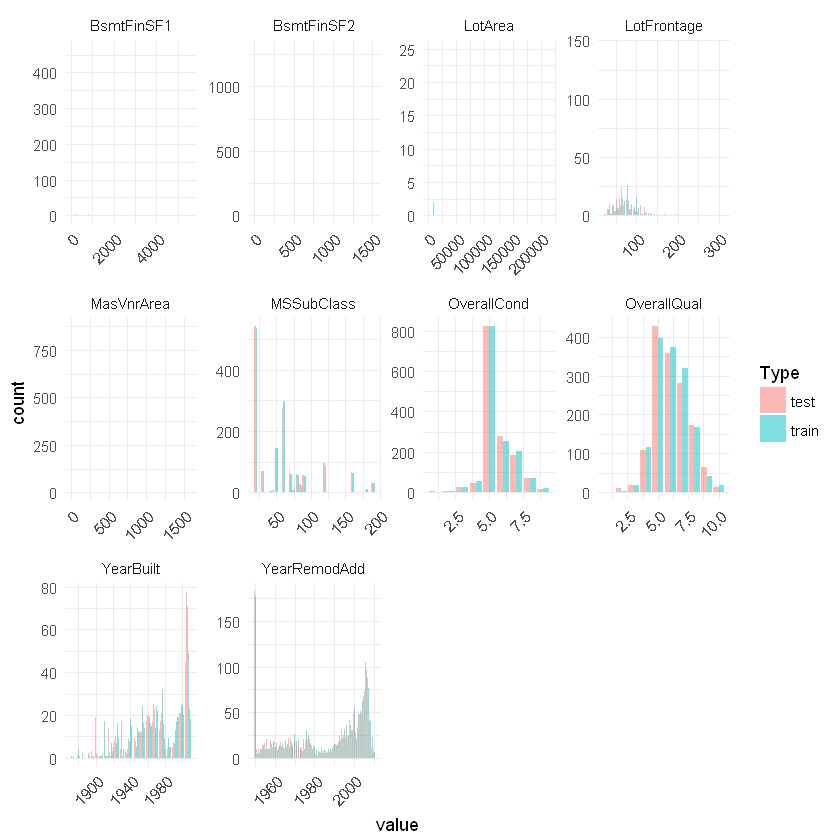

In [38]:
# Distributions
train_num$Type <- "train"
train_num$SalePrice <- NULL
test_num$Type <- "test"

all_num <- rbind(train_num, test_num)
all_num$Id <- NULL

# 4 different plots, just to have bigger plots
names <- colnames(all_num)
all_num %>%
  gather(key, value, -Type) %>% 
  filter(key %in% names[1:10]) %>%
  ggplot(aes(value, fill=Type)) +
  facet_wrap(~ key, scales = "free") +
  geom_histogram(stat="count", position="dodge", alpha=0.5) +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Removed 6 rows containing non-finite values (stat_count)."Warning message:
"position_dodge requires non-overlapping x intervals"

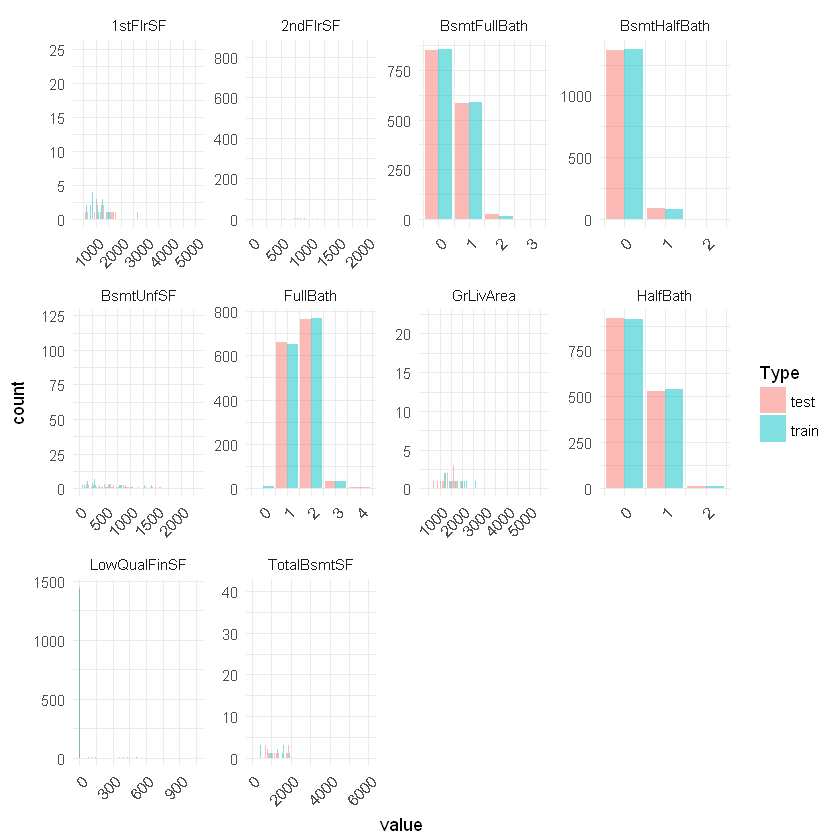

In [37]:
all_num %>%
  gather(key, value, -Type) %>% 
  filter(key %in% names[11:20]) %>%
  ggplot(aes(value, fill=Type)) +
  facet_wrap(~ key, scales = "free") +
  geom_histogram(stat="count", position="dodge", alpha=0.5) +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"Removed 161 rows containing non-finite values (stat_count)."

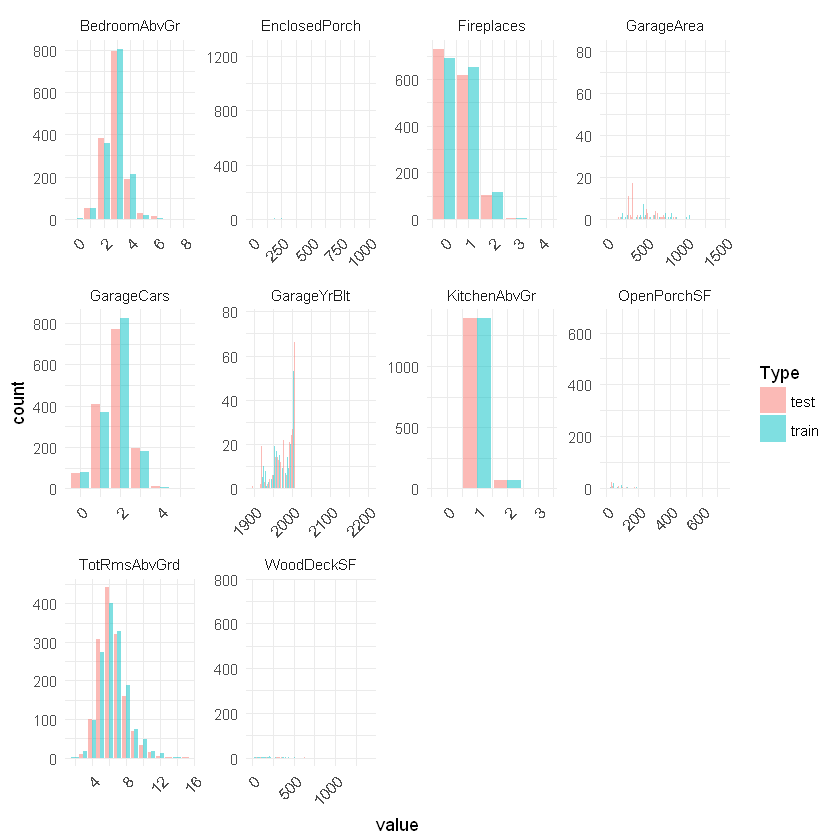

In [39]:
all_num %>%
  gather(key, value, -Type) %>% 
  filter(key %in% names[21:30]) %>%
  ggplot(aes(value, fill=Type)) +
  facet_wrap(~ key, scales = "free") +
  geom_histogram(stat="count", position="dodge", alpha=0.5) +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"Warning message:
"position_dodge requires non-overlapping x intervals"Warning message:
"position_dodge requires non-overlapping x intervals"Warning message:
"position_dodge requires non-overlapping x intervals"

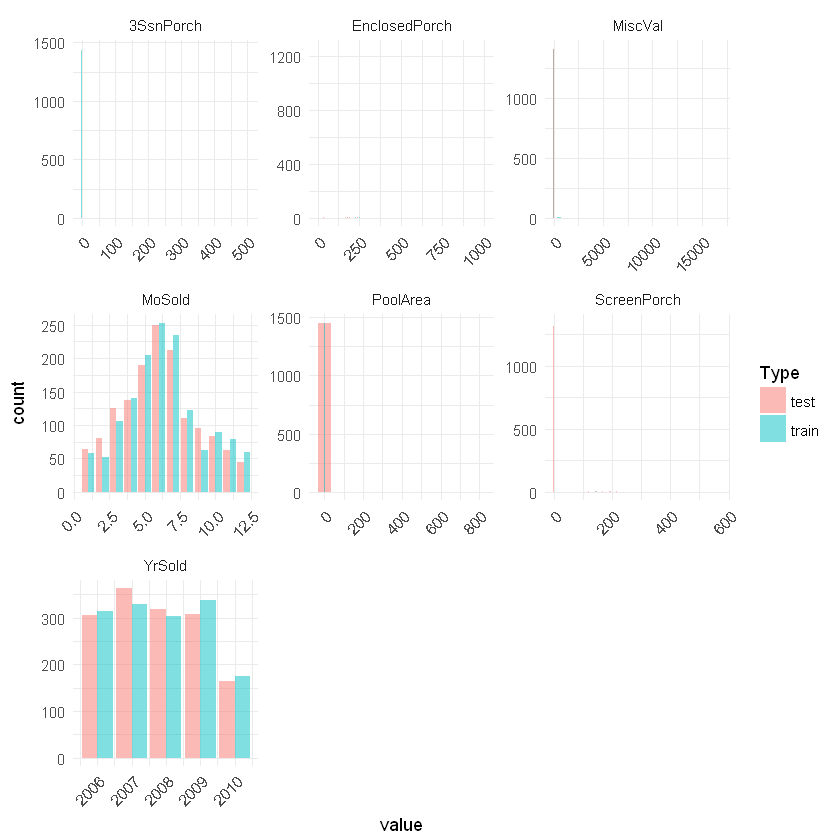

In [40]:
all_num %>%
  gather(key, value, -Type) %>% 
  filter(key %in% names[30:ncol(all_num)]) %>%
  ggplot(aes(value, fill=Type)) +
  facet_wrap(~ key, scales = "free") +
  geom_histogram(stat="count", position="dodge", alpha=0.5) +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

* Train and test show similar distributions, and also the same peaks.
* The test set has a garage built in 2200! We can replace it with the year the house was built.
* Some Values have non-gaussian distributions, we can fix those too as we did for the sale price.
* A lot of features have strong peaks in 0, usually a sign that a certain feature is absent.

***

###  <span style="color:#2E66A7">Analysis of missing values</span>

We should take a closer look at the missing values, and try to understand why they are missing and what should be the best approach to replace them, if possible.

In [44]:
na_train <- data.frame(col=colnames(train),
                       col_type=sapply(train, class),
                       na_sum=apply(X = train, MARGIN = 2, FUN=function(x) sum(is.na(x))),
                       na_perc=apply(X = train, MARGIN = 2, FUN=function(x) sum(is.na(x))/length(x)), row.names = NULL)
na_train <- na_train[order(na_train$na_perc, decreasing = T), ]
na_train[1:20, ]

,col,col_type,na_sum,na_perc
73,PoolQC,character,1453,0.9952054795
75,MiscFeature,character,1406,0.9630136986
7,Alley,character,1369,0.9376712329
74,Fence,character,1179,0.8075342466
58,FireplaceQu,character,690,0.4726027397
4,LotFrontage,integer,259,0.1773972603
59,GarageType,character,81,0.0554794521
60,GarageYrBlt,integer,81,0.0554794521
61,GarageFinish,character,81,0.0554794521
64,GarageQual,character,81,0.0554794521


In the training set there are about 20 features that have missing values. In some cases, the number of missing values is really high, which could strongly relate to an hidden meaning of the missing values (e.g. the lack of a basement, or a pool).

In other cases, we can assume that the values are just missing at random, and no special meaning is related to their absence.

* A few columns have really **high NA count**. Probably the NA has a meaning, we can replace it with a default value.
* **PoolQC** is NA if no pool is present.
* **MiscFeature** is NA if no special feature is present.
* In the features with a high percentage of missing values, it's probably better to use a **binary variable** (e.g. PoolPresent = Y/N), instead of something more specific (e.g. pool area).
* We can do this for **PoolQC**, **MiscFeature**, **Alley** and **Fence**.
* **FireplaceQu** is better kept as is, because a good amount of rows has meaningful values, but we can still add a default value for when no fireplace is present.
* Other **missing** data are **connected** with each other (e.g. features related to garage).
* We'll see what to do with them later, depending on how useful they are in the predictions and depending on whether the test set also has missing values in the same places.

In [48]:
na_test <- data.frame(col=colnames(test),
                       col_type=sapply(test, class),
                       na_sum=apply(X = test, MARGIN = 2, FUN=function(x) sum(is.na(x))),
                       na_perc=apply(X = test, MARGIN = 2, FUN=function(x) sum(is.na(x))/length(x)), row.names = NULL)
na_test <- na_test[order(na_test$na_perc, decreasing = T), ]
na_test[1:35, ]

,col,col_type,na_sum,na_perc
73,PoolQC,character,1456,0.997943797
75,MiscFeature,character,1408,0.965044551
7,Alley,character,1352,0.926662097
74,Fence,character,1169,0.801233722
58,FireplaceQu,character,730,0.500342700
4,LotFrontage,integer,227,0.155586018
60,GarageYrBlt,integer,78,0.053461275
61,GarageFinish,character,78,0.053461275
64,GarageQual,character,78,0.053461275
65,GarageCond,character,78,0.053461275


The test set has a similar NA distribution, but there are more columns with 1 or 2 values missing. 
We might have to do a bit of fine-grain data cleaning to handle them.

***

###  <span style="color:#2E66A7">Correlation with the target</span>

How are the features connected to the target?  
Features that are strongly correlated to the sale price will be very likely to be more useful in the predictions, and we would like to identify them as early as possible.  
The idea is that we can try to extract even more information from them, for instance by adding a discretized, *rough-grain*, version of them alongside the original version.  
Vice-versa, features that are weakly related to the output will hardly be useful, and we can avoid too much time spend time on them.

We should be careful, however, as correlation doesn't depict the whole picture. Some features could be of little use by themselves, but be useful if taken together, for instance.  
Another thing that could happen is that 2 features that are strongly connected to the output are also strongly correlated with each other. In this case, keeping both won't be of much use, and could even negatively impact some algorithms (ever tried to invert a matrix with linearly dependent columns?)

Also, **Pearson** correlation is defined only for numerical variables. To understand how categorical features are connected to the output we need some different approach. We'll see later how to deal with that, but first let's look at the numerical features.

In [51]:
# First, inspect the correlation of numerical features with the target
train_num <- keep(train, is.numeric)
train_num$Id <- NULL
correlations <- cor(na.omit(train_num))
sales_cor <- data.frame(var=names(correlations[37, ]), correlation=correlations[37, ], row.names=NULL)

p <- figure(width = 1200, height=800) %>% 
  ly_bar(x=var, y=correlation, data=sales_cor) %>%
  theme_axis(major_label_orientation = 45) %>%
  x_range(dat=sales_cor[order(sales_cor$correlation, decreasing = T), ]$var)
rbokeh2html(p,'./out.html')
IRdisplay::display_html(file='./out.html')

html file written to: ./out.html


<!DOCTYPE html>

Here we can see how various numerical features are connected to **SalePrice**. The overall quality of the house is the strongest predictor, along with the size of various parts of the house.  
The garage size and the number of cars are both very useful, but they are also probably correlated to each other. It might not be a good idea to keep both, we'll see!  
The number of bathrooms is also pretty useful, too.

On the other side of the spectrum, having an enclosed porch seems to be a bad thing (maybe it's more common in older farm houses), along with having kitchens above ground.

Surprisingly, a better overall condition of the house is linked to lower prices.

In [52]:
hist(train$OverallCond)

p <- figure() %>% 
  ly_boxplot(x=OverallCond, y=SalePrice, data=train) %>%
  theme_axis(major_label_orientation = 45) 
rbokeh2html(p,'./out.html')
IRdisplay::display_html(file='./out.html')

both x and y are numeric -- choosing numeric variable based on which has the most unique values
html file written to: ./out.html


<!DOCTYPE html>

It seems that an average **OverallCond** is often found in expensive houses too. Low quality is associated to low prices though, and there are many outliers, so the negative correalation is partially misleading. Also, an overall quality of 5 is by far the most common value, which suggests that the feature isn't really as useful as one might expect.

In [54]:
p <- figure() %>% 
  ly_boxplot(x=YrSold, y=SalePrice, data=train) %>%
  theme_axis(major_label_orientation = 45) 
rbokeh2html(p,'./out.html')
IRdisplay::display_html(file='./out.html')

both x and y are numeric -- choosing numeric variable based on which has the most unique values
html file written to: ./out.html


<!DOCTYPE html>

Also quite surprising is that the year of the sale doesn't affect the sale price. Considering that the sales were done between 2006 and 2010, it seems that the house market bubble didn't hit Ames at all!

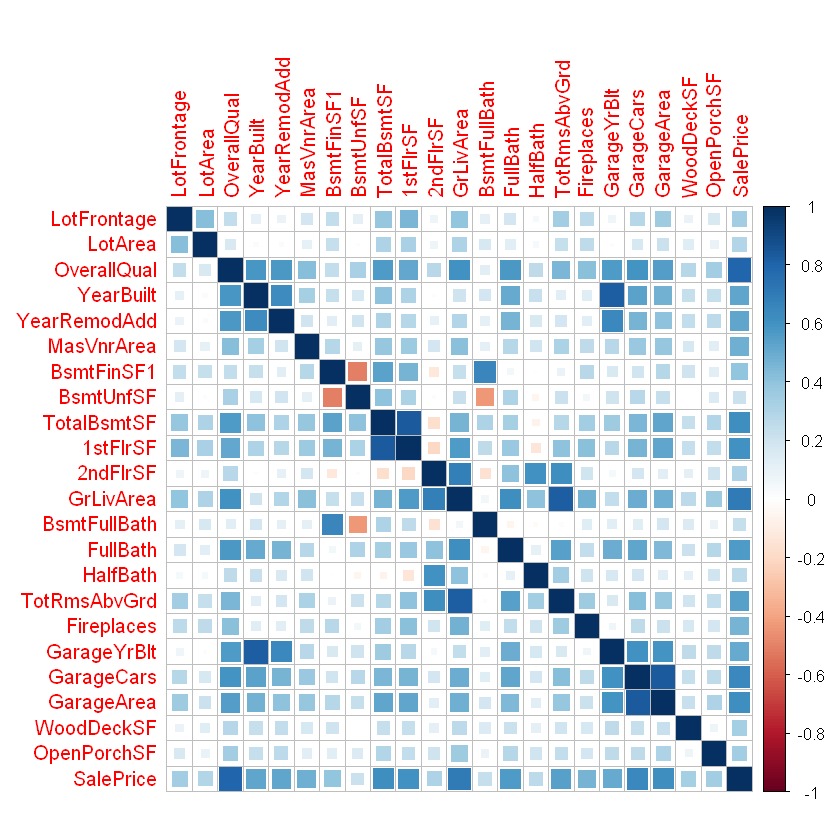

In [56]:
indices <- abs(correlations[37, ]) > 0.2
corrplot(correlations[indices, indices], method="square")

For the numerical features that are the most connected to the output, we can see how they are correlated with each other.  
Unsurprisingly, the features that relate to the same topic (e.g. **Garage**) are all very connected, and the same happens for numerical features that are connected by some arithmetic relation: for instance, the areas of finished and unfinished basement surface, which sum up to the total basement area.

In [57]:
train[1:20, c("BsmtUnfSF", "BsmtFinSF1", "BsmtFinSF2", "TotalBsmtSF")]

BsmtUnfSF,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF
150,706,0,856
284,978,0,1262
434,486,0,920
540,216,0,756
490,655,0,1145
64,732,0,796
317,1369,0,1686
216,859,32,1107
952,0,0,952
140,851,0,991


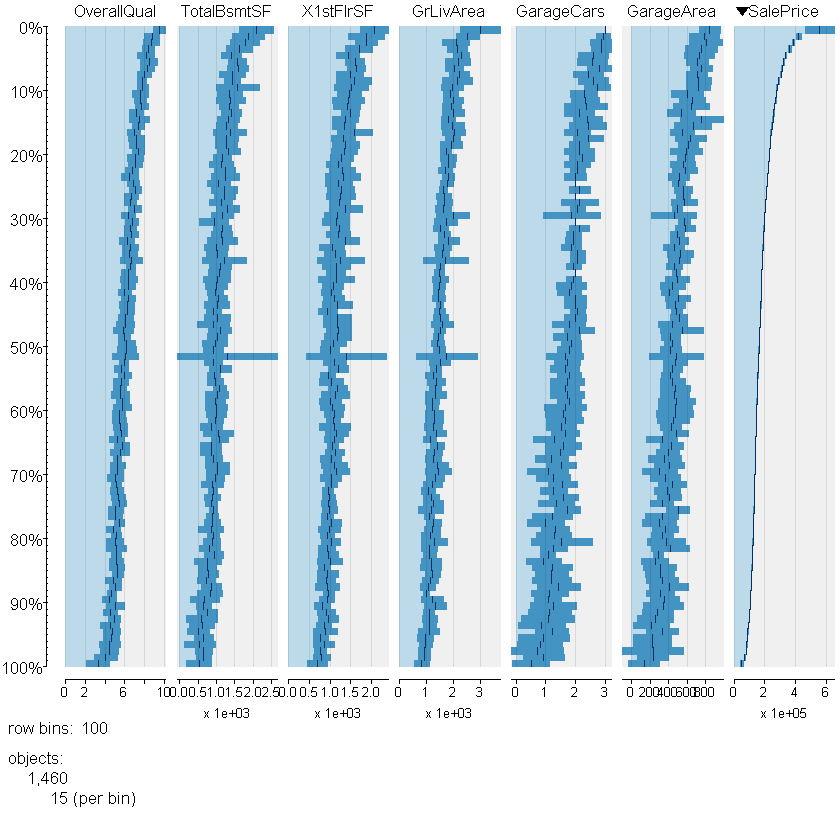

In [58]:
indices <- abs(correlations[37, ]) > 0.6
tableplot(train_num[, indices], cex=1.8, sortCol = "SalePrice")

In this plot we see how some numerical features such as **OverallQuality** and **GarageArea** are connected to the **SalePrice**.  
The intuitive explanation is that higher sale prices are connected to higher values of quality and surface areas.

Now, let's inspect more in details the features that are correlated the most with the sale prices.  
First, we can draw some scatter plots, and see what the relation between the 2 variables actually is.

In [59]:
p <- figure(legend_location = NULL) %>%
  ly_points(train_num$OverallQual, train_num$SalePrice, color=train_num$OverallQual) %>%
  ly_abline(lm(SalePrice ~ OverallQual, data=train_num), width=2, type=2)
rbokeh2html(p,'./out.html')
IRdisplay::display_html(file='./out.html')

html file written to: ./out.html


<!DOCTYPE html>

We can see that the relation between overall quality and price isn't exaclty linear, but quadratic or exponential. Also, there are few high quality houses, and the variance in prices goes up with the quality too!

In [60]:
p <- figure(legend_location = NULL) %>%
  ly_points(train_num$GrLivArea, train_num$SalePrice, color=train_num$GrLivArea) %>%
  ly_abline(lm(SalePrice ~ GrLivArea, data=train_num), width=2, type=2)
rbokeh2html(p,'./out.html')
IRdisplay::display_html(file='./out.html')

html file written to: ./out.html


<!DOCTYPE html>

There are a couple of outliers: some of them have very high price and area, but are aligned to the linear trend.  
2 others, instead, have low price and very high area. It might be better to just remove those observations from the dataset, as they could negatively bias the entire model.

In [62]:
p <- figure(legend_location = NULL) %>%
  ly_points(train_num$GarageCars, train_num$SalePrice, color=train_num$GarageCars) %>%
  ly_abline(lm(SalePrice ~ GarageCars, data=train_num), width=2, type=2)
rbokeh2html(p,'./out.html')
IRdisplay::display_html(file='./out.html')

html file written to: ./out.html


<!DOCTYPE html>

The number of garage cars seems related to the saleprices, but garages with 4 cars seems to be associated with cheaper houses (maybe farms?). Once again, the variance goes up with the trend.  
This is confirmed by the following boxplot.

In [64]:
p <- figure(legend_location = NULL) %>%
  ly_boxplot(x=GarageCars, y=SalePrice, group=GarageCars, data=train_num)
rbokeh2html(p,'./out.html')
IRdisplay::display_html(file='./out.html')

both x and y are numeric -- choosing numeric variable based on which has the most unique values
html file written to: ./out.html


<!DOCTYPE html>

In [63]:
p <- figure(legend_location = NULL) %>%
  ly_points(train_num$GarageArea, train_num$SalePrice, color=train_num$GarageArea) %>%
  ly_abline(lm(SalePrice ~ GarageArea, data=train_num), width=2, type=2)
rbokeh2html(p,'./out.html')
IRdisplay::display_html(file='./out.html')

html file written to: ./out.html


<!DOCTYPE html>

We can immediately see a chunk of houses with no garage (area 0), which have in general a low price. There are once again some houses with low price and large garage. 
Maybe they are the same houses that had very large area and low price, or the houses with 4-cars garages.